In [1]:
import pandas as pd
import librosa
import h5py
import matplotlib.pylab as plt
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
days = [2, 3, 4]
sessions = [1, 2, 3]
channels = [1, 2, 3]
sampling_rate = 48000

In [3]:
def get_file_path(day, session, channel):
    return 'raw_data/feb' + str(day) + '/session' + str(session) + '/channel' + str(channel) + '.wav'

Read in the signature whistle labels. Get rid of any labels where the recorders didn't agree on which dolphin it was.

In [4]:
df = pd.read_csv('signature_whistle_labels_new.tsv', sep="\t")

df = df.loc[df.ID1 == df.ID2]

dolphins = df.ID1.unique().tolist()

df['start_time_point'] = df.start_time_seconds.apply(lambda x: int(x * sampling_rate))
df['end_time_point'] = df.end_time_seconds.apply(lambda x: int(x * sampling_rate))

df

,chicago_time,hydrophone,start_time,end_time,channel,ID1,ID2,dolphin_A,dolphin_C,dolphin_L,dolphin_M,dolphin_N,dolphin_S,dolphin_T,start_time_seconds,end_time_seconds,day,session,start_time_point,end_time_point
0,08:00:31.9,1.0,00:13:45.9,00:13:47.1,1,A,A,1,1,3,1,1,1,1.0,825.9,827.1,2,1,39643200,39700800
1,08:01:02.4,1.0,00:14:16.4,00:14:16.9,1,K,K,1,1,1,1,1,1,1.0,856.4,856.9,2,1,41107200,41131200
2,08:01:46.5,1.0,00:15:00.5,00:15:01.1,1,N,N,1,1,4,1,1,1,1.0,900.5,901.1,2,1,43224000,43252800
3,08:02:04.8,2.0,00:15:18.8,00:15:19.5,2,K,K,1,1,2,1,1,1,1.0,918.8,919.5,2,1,44102400,44136000
4,08:02:05.8,1.0,00:15:19.8,00:15:20.5,1,K,K,1,1,2,1,1,1,1.0,919.8,920.5,2,1,44150400,44184000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5060,16:24:35.3,4.0,01:38:03.3,01:38:03.8,3,K,K,1,4,1,1,1,2,1.0,5883.3,5883.8,4,3,282398400,282422400
5064,16:45:40.8,1.0,01:59:08.8,01:59:09.4,1,K,K,1,1,1,1,1,2,1.0,7148.8,7149.4,4,3,343142400,343171200
5068,16:50:07.6,1.0,02:03:35.6,02:03:36.3,1,N,N,1,4,1,1,1,3,1.0,7415.6,7416.3,4,3,355948800,355982400
5069,16:50:14.1,1.0,02:03:42.1,02:03:42.6,1,N,N,1,3,1,1,1,3,1.0,7422.1,7422.6,4,3,356260800,356284800


In [5]:
signature_whistles =  {dolphin: [] for dolphin in dolphins}

for day in days:
    for session in sessions:
        for channel in channels:
                
            fname = get_file_path(day, session, channel)
            wave, _ = librosa.load(fname, sr = sampling_rate)
                
            for dolphin in dolphins:
                
                whistles = []
                
                df_tmp = df.loc[(df.day == day) & (df.channel == channel) & (df.session == session) & (df.ID1 == dolphin)] # .reset_index()
                
                for i, row in df_tmp.iterrows():
                    whistles.append((i, np.copy(wave[row['start_time_point']:row['end_time_point']])))
                    # whistles.append(np.copy(wave[row['start_time_point']:row['end_time_point']]))
                
                signature_whistles[dolphin] = signature_whistles[dolphin] + whistles
                
            # break
        # break
    # break

In [6]:
print("Number of signature whistle occurences:")
for dolphin, whistles in signature_whistles.items():
    print("Dolphin " + dolphin + ": " + str(len(whistles)))

Number of signature whistle occurences:
Dolphin A: 360
Dolphin K: 1395
Dolphin N: 311
Dolphin C: 808
Dolphin T: 773
Dolphin Z: 83
Dolphin M: 483


In [7]:
def plot_sig_whistles(dolphin, same_scale=True):
    
    n = 21

    # plt.close('all')
    random.seed(1)
    sigs = random.choices(signature_whistles[dolphin], k=n)

    max_val = 0
    min_val = 0
    for i in range(n):
        val = np.max(sigs[i][1])
        if val > max_val: max_val = val
        val = np.min(sigs[i][1])
        if val < min_val: min_val = val

    fig, axes = plt.subplots(7,3, figsize=(15,15))  
    for i in range(7):
        for j in range(3):
            axes[i,j].plot(sigs[i*3+j][1])
            if same_scale: axes[i,j].set_ylim([min_val,max_val])
            axes[i,j].set_title("Start time: " + df.loc[sigs[i*3+j][0],'start_time'] + "; End time: " + df.loc[sigs[i*3+j][0],'end_time'])
    fig.suptitle('Signature Whistles for dolphin ' + dolphin, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


### Display 21 random examplar signature whistles for each dolphin based on hand-labeled data setting the y-axis to the same scale.

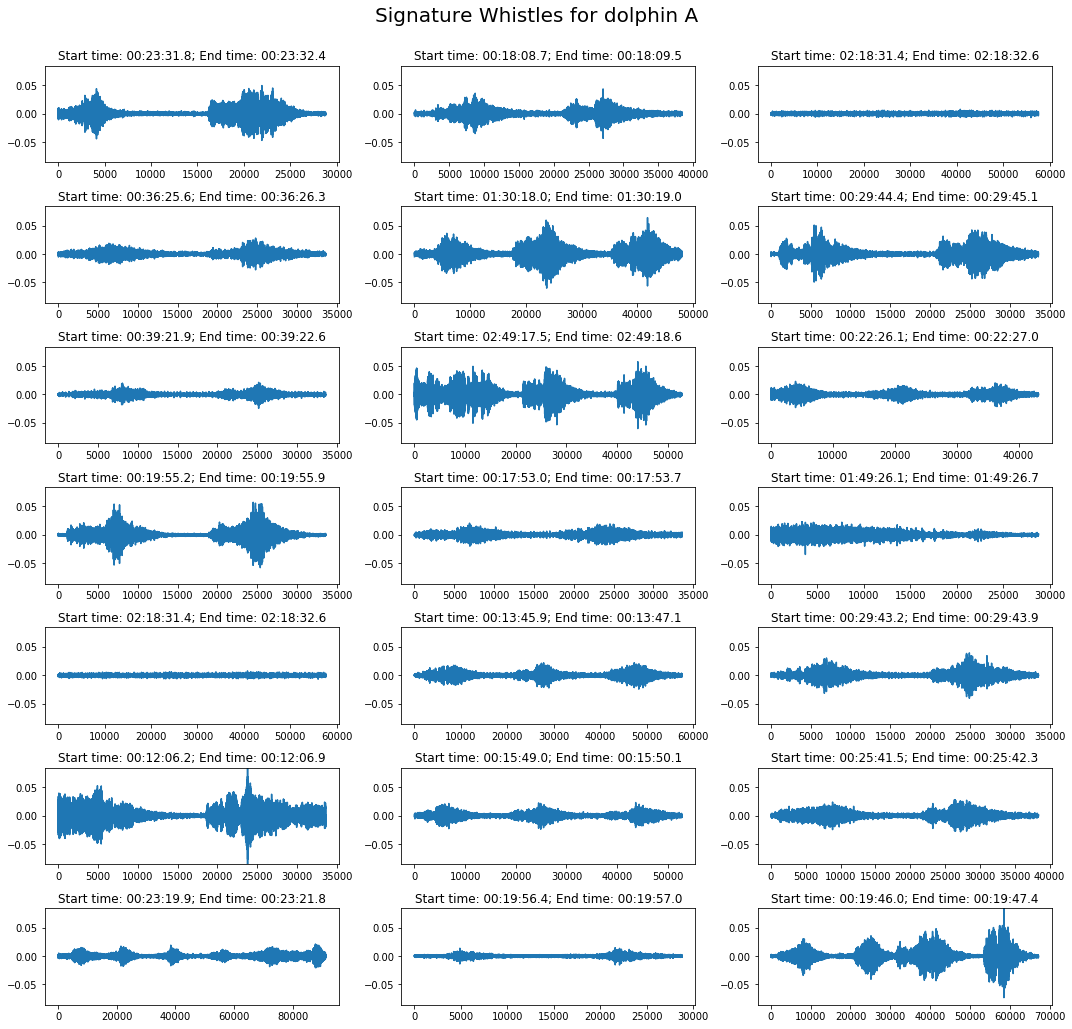

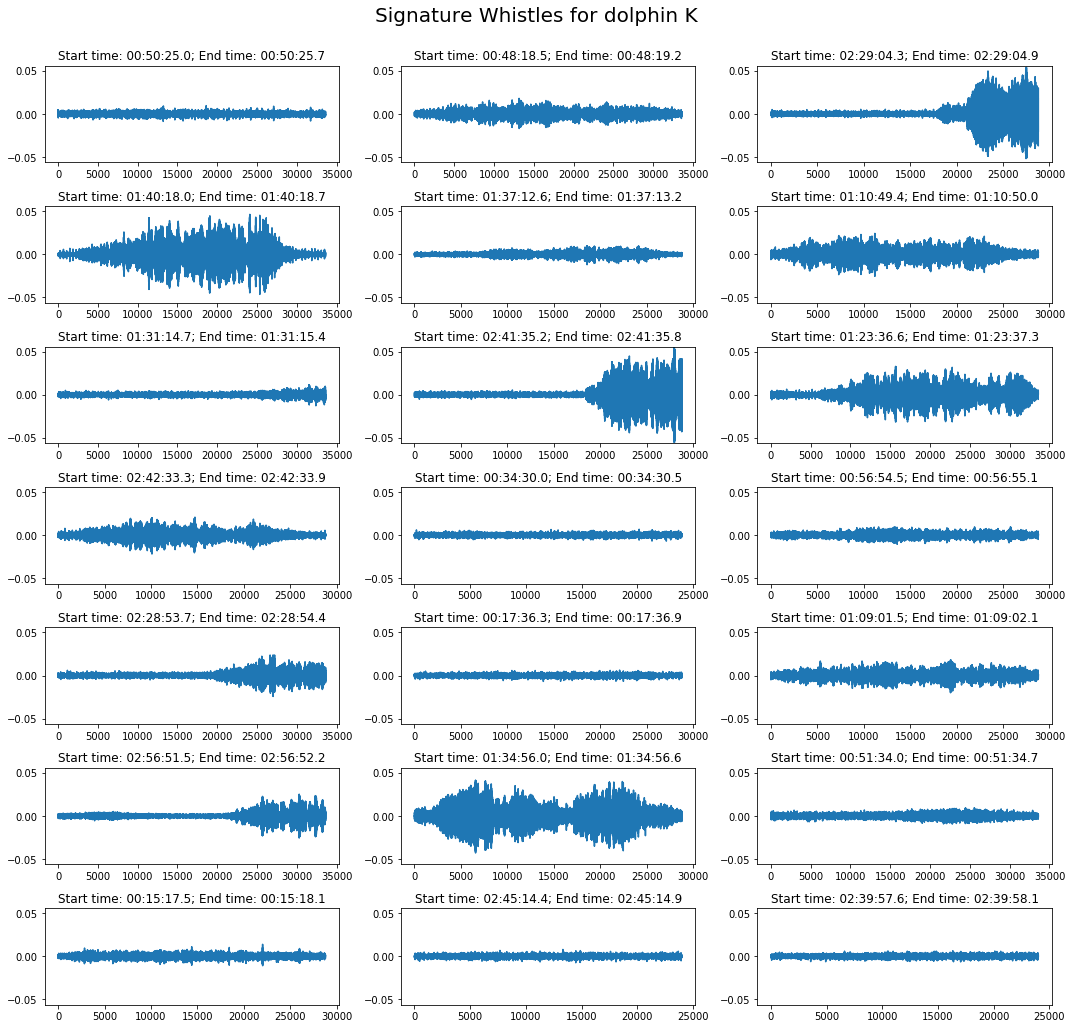

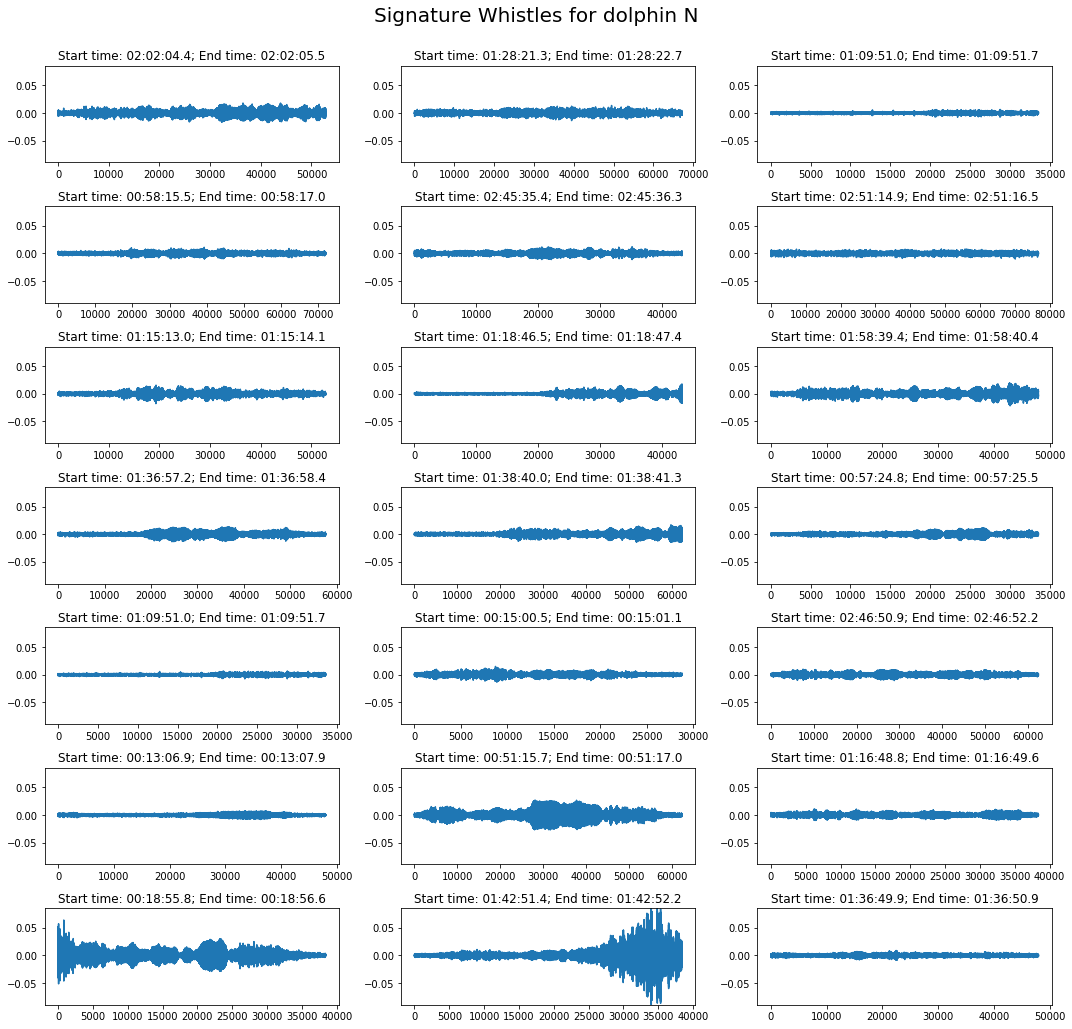

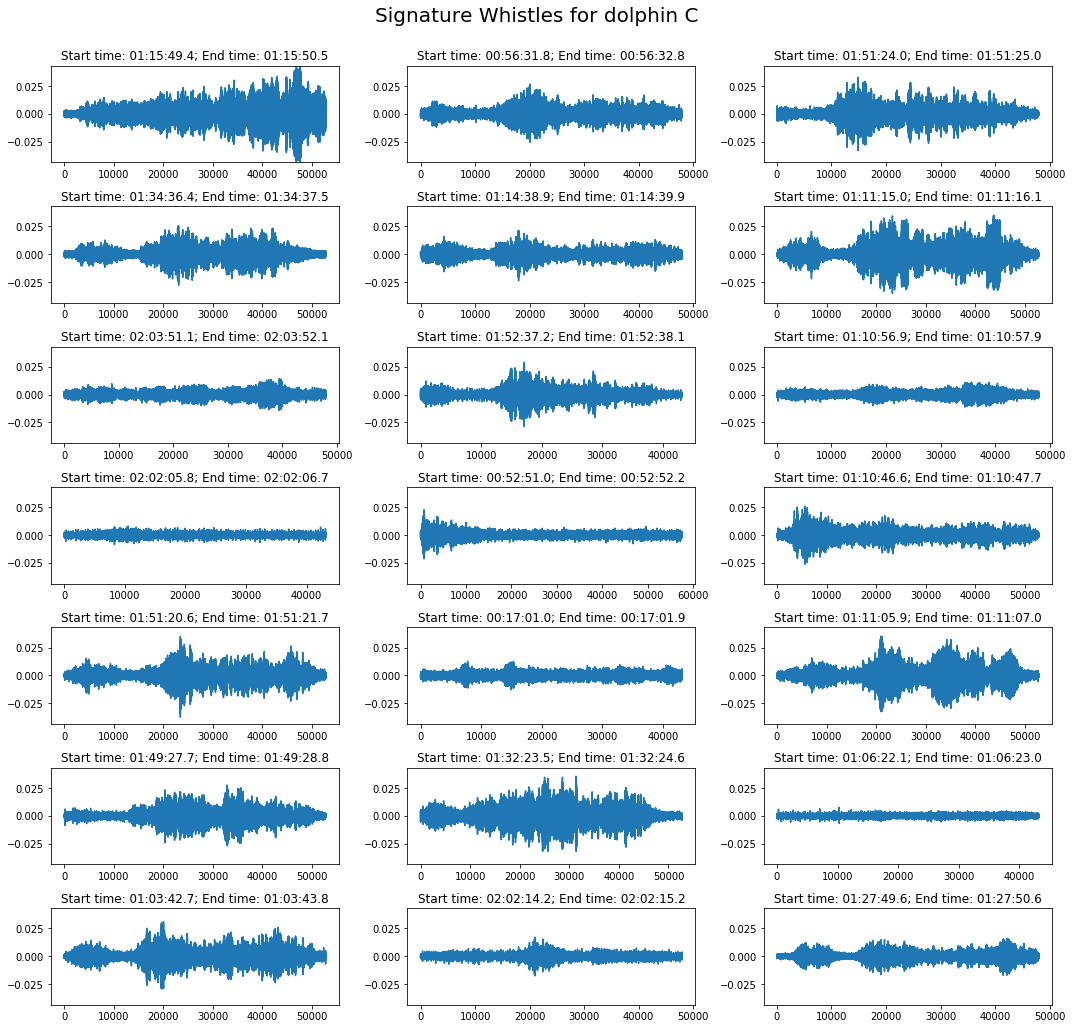

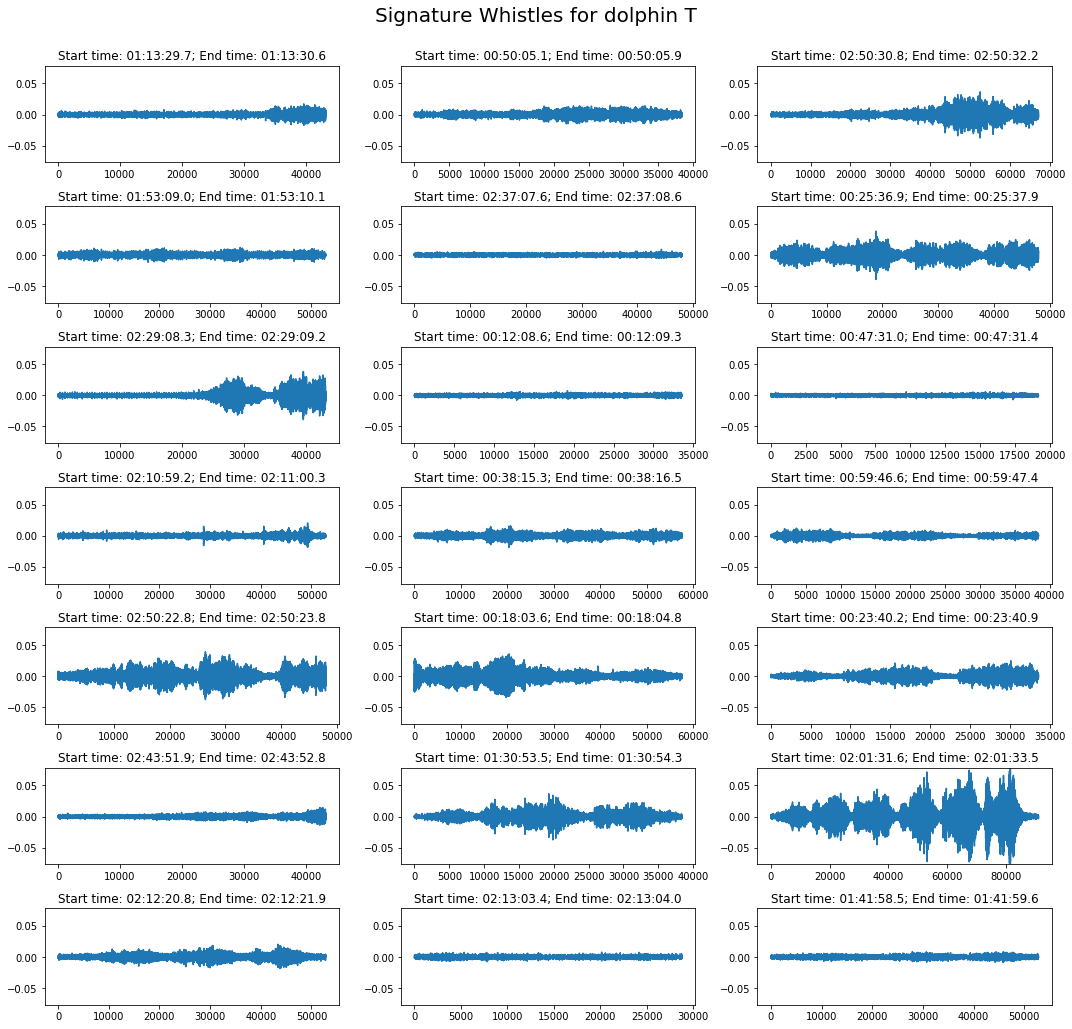

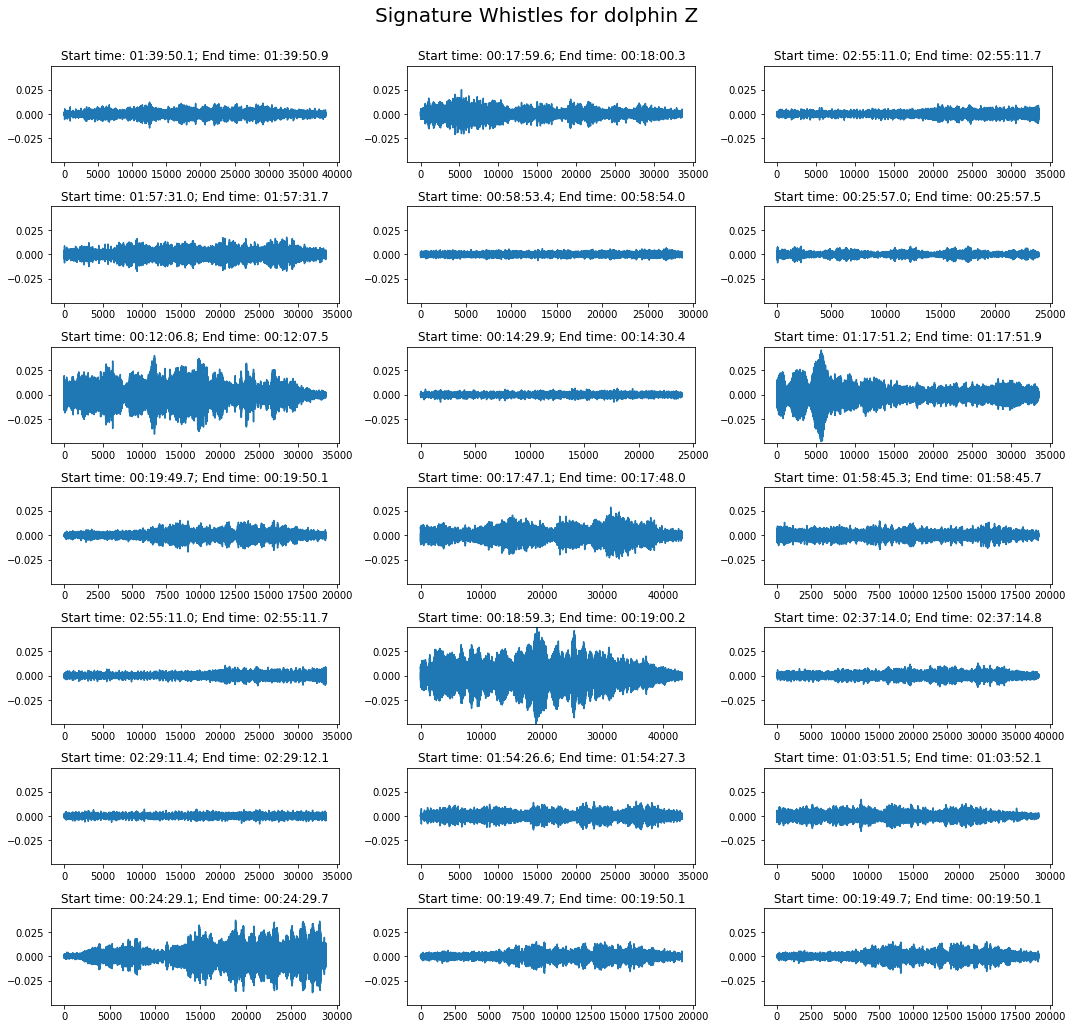

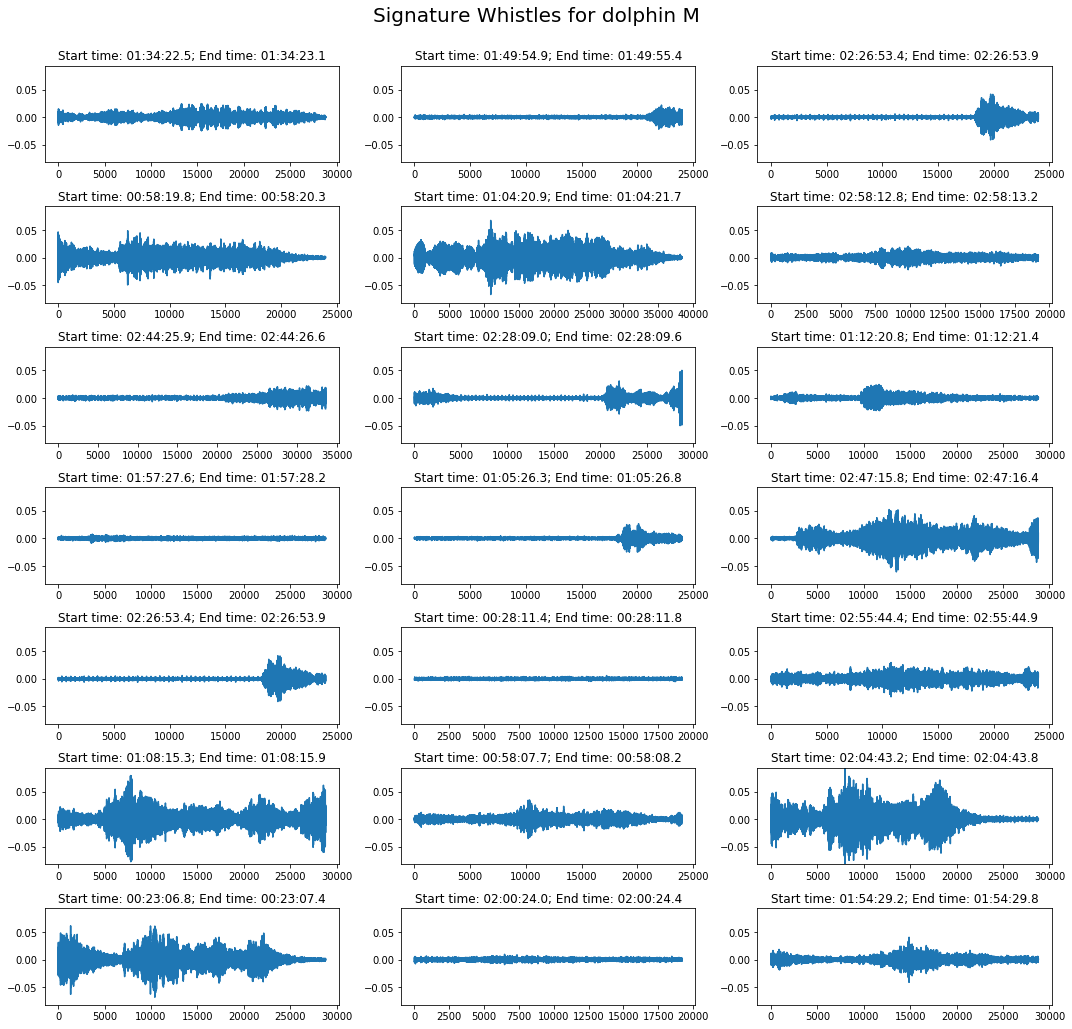

In [8]:
for dolphin in dolphins: plot_sig_whistles(dolphin, same_scale=True)

### Display 21 random examplar signature whistles for each dolphin based on hand-labeled data allow the y-axis to vary in scale.

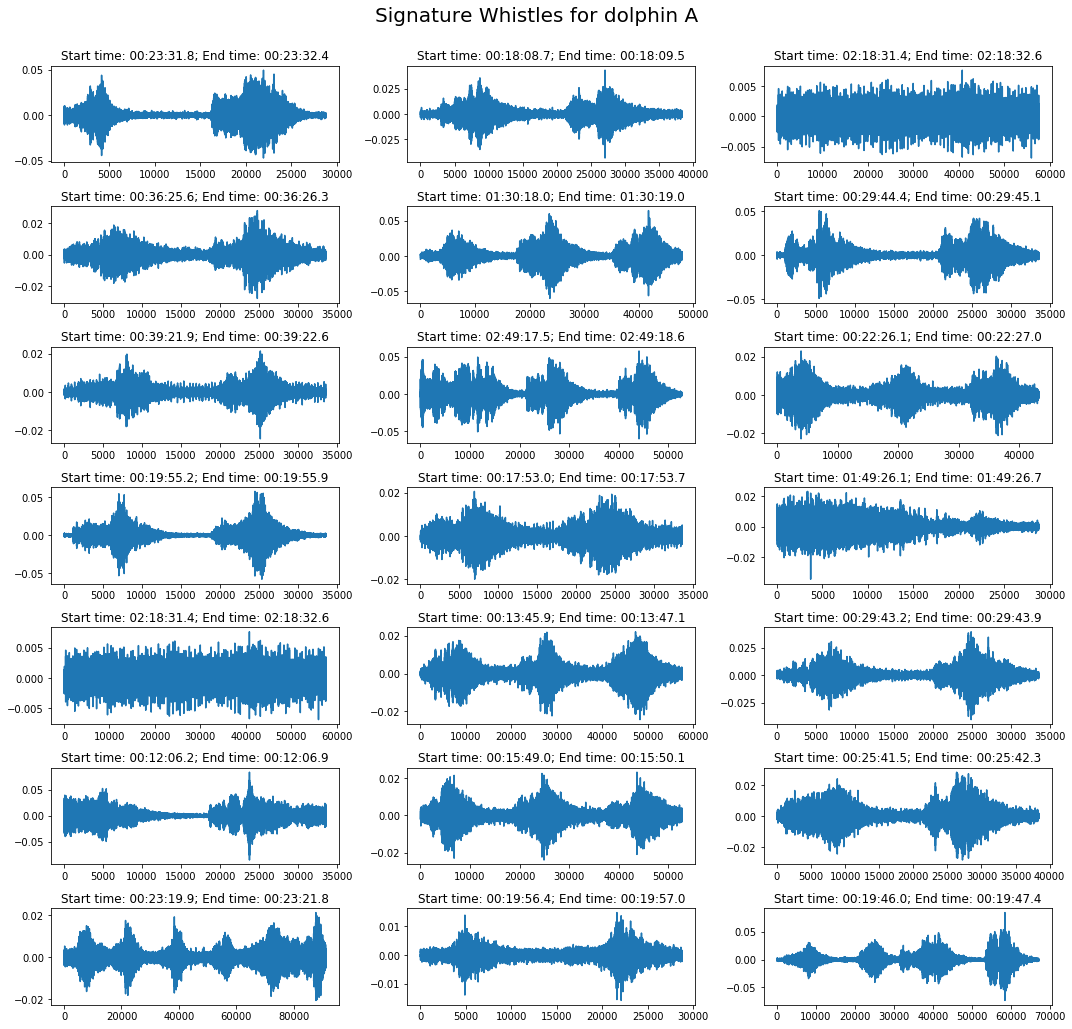

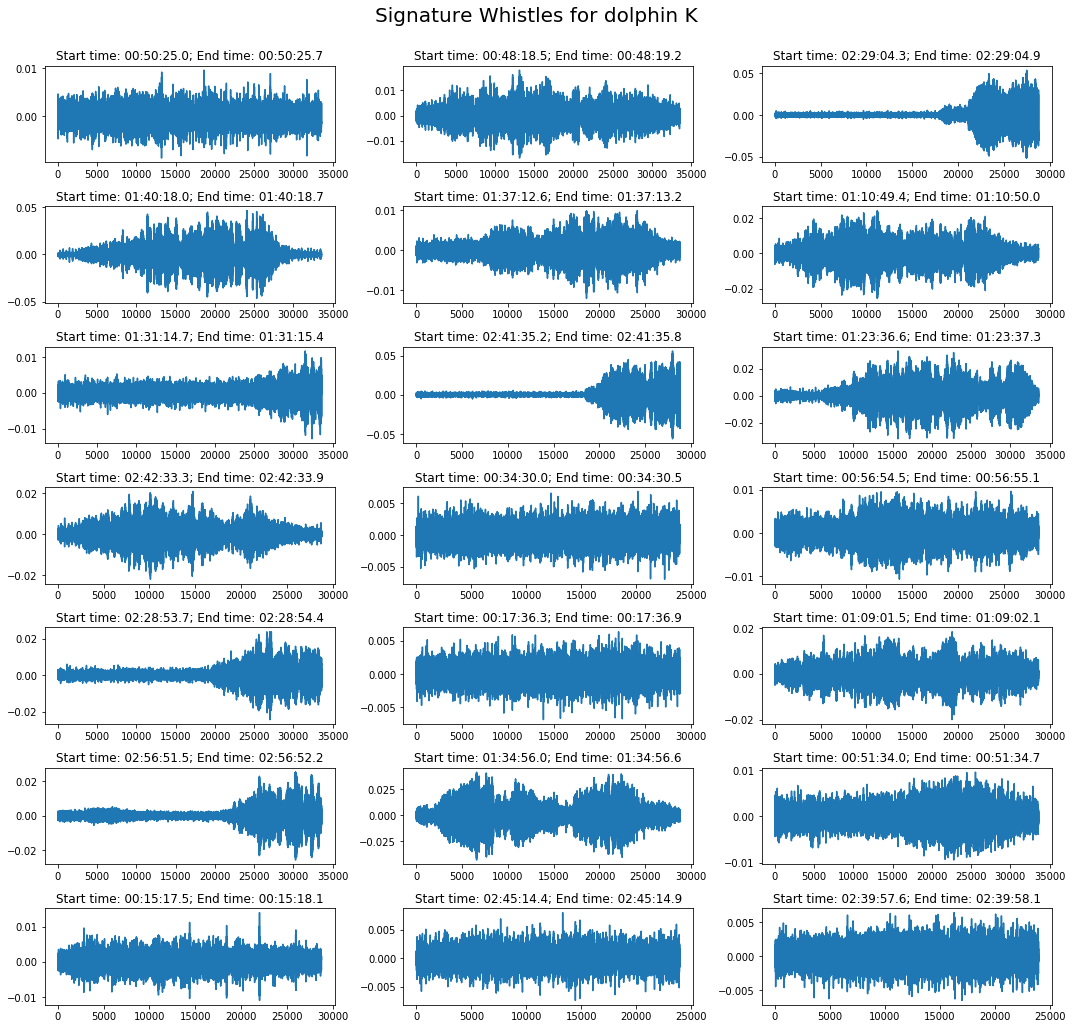

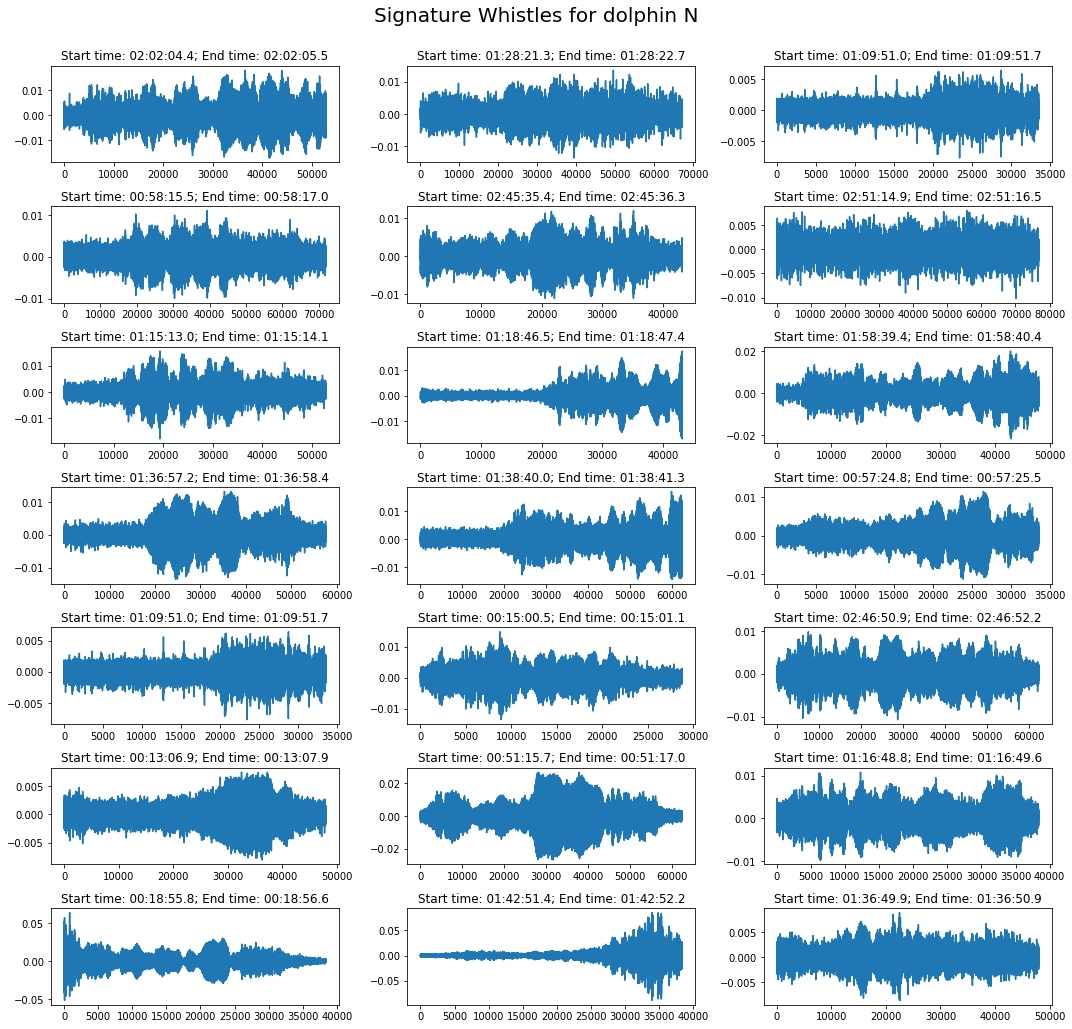

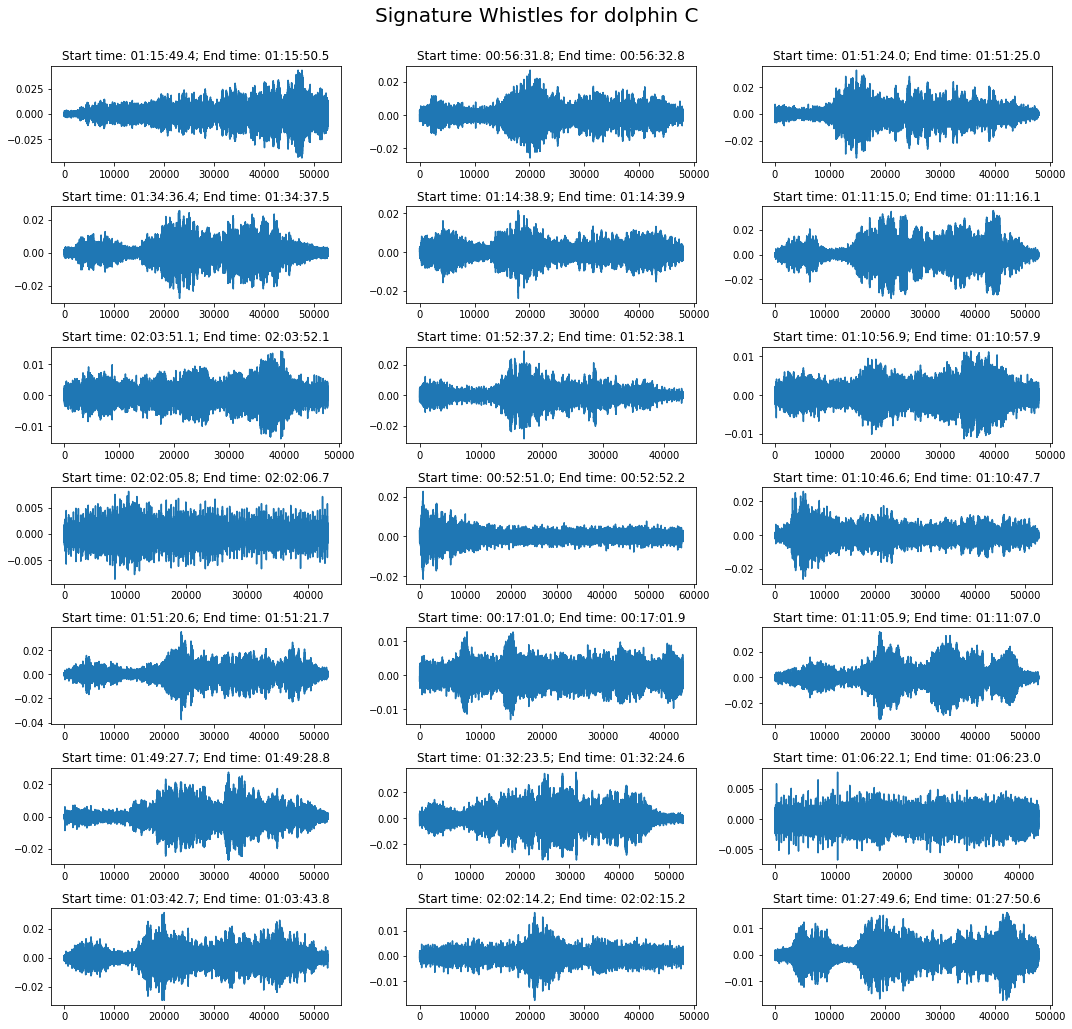

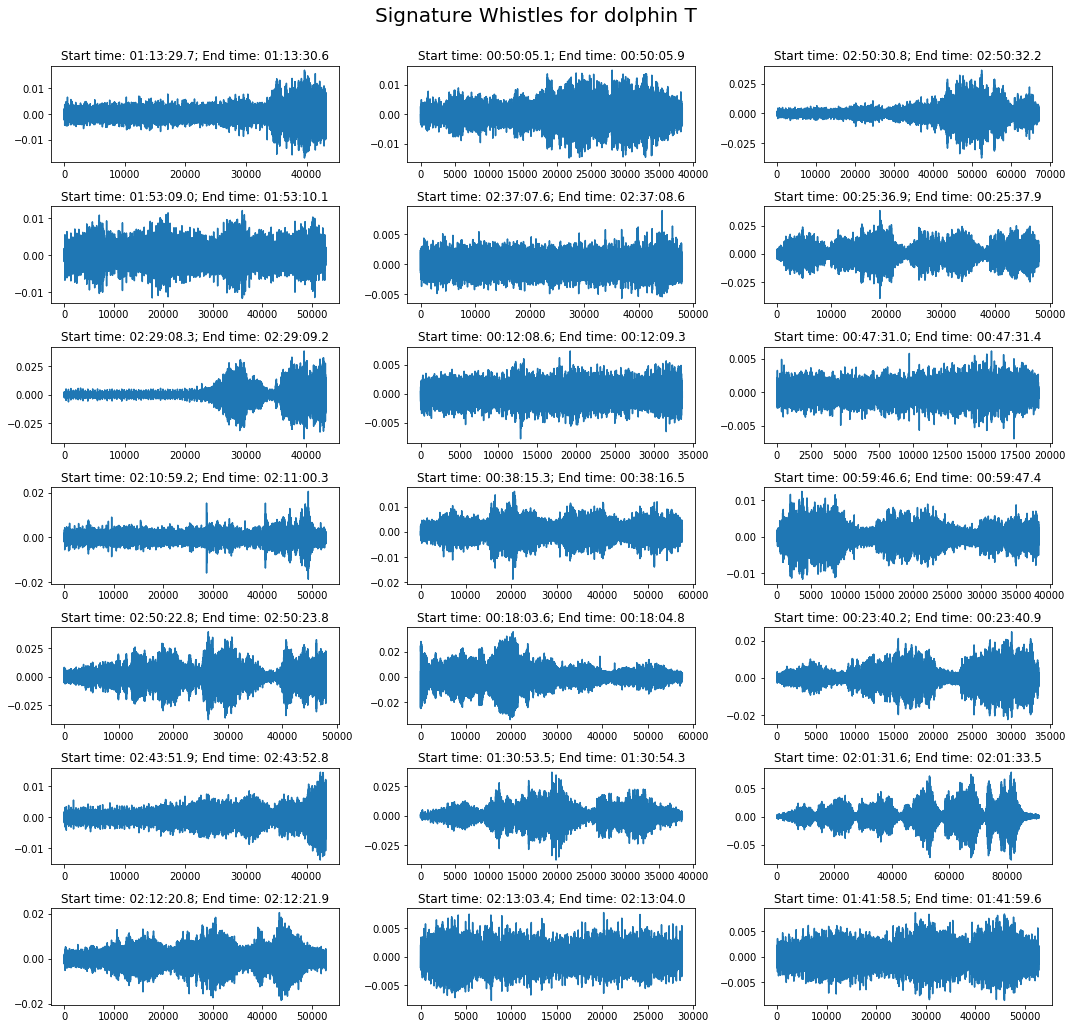

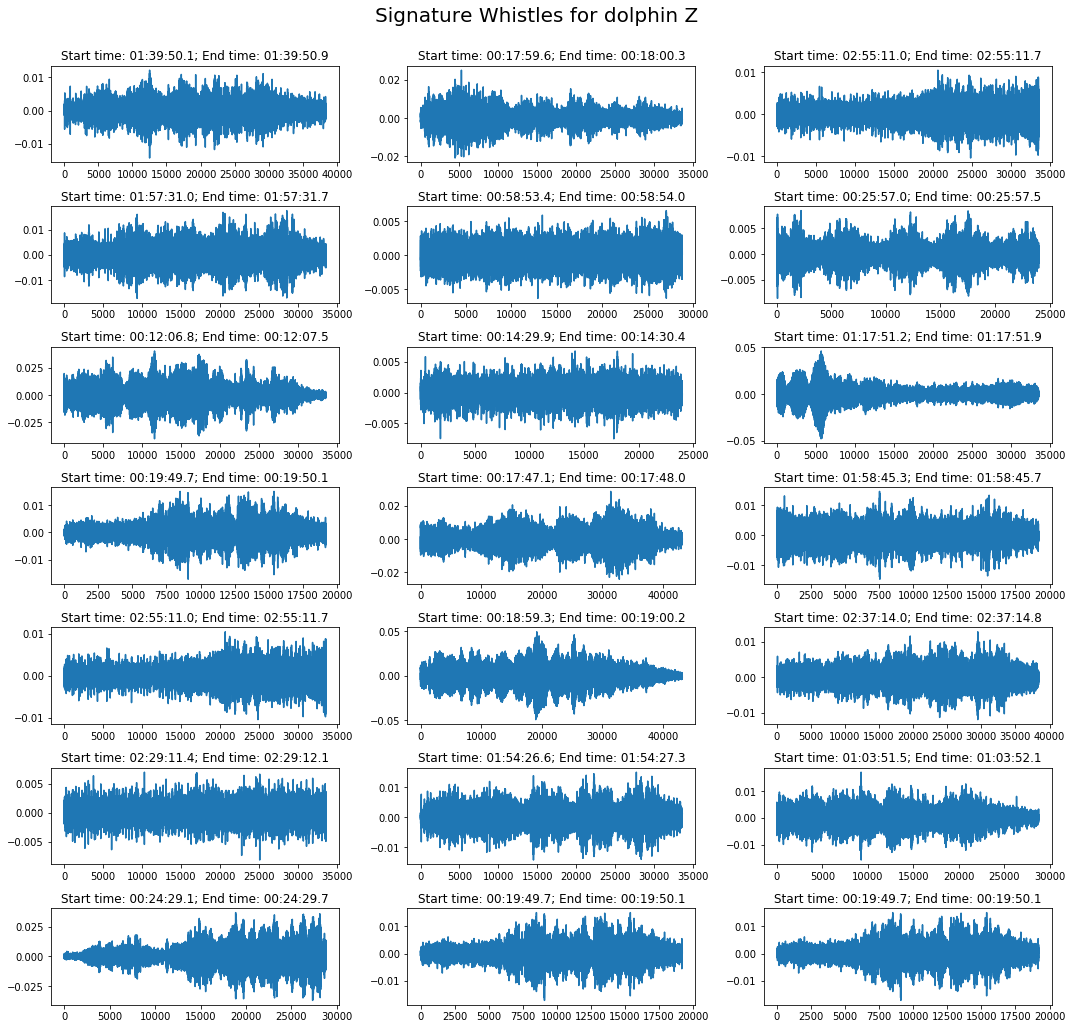

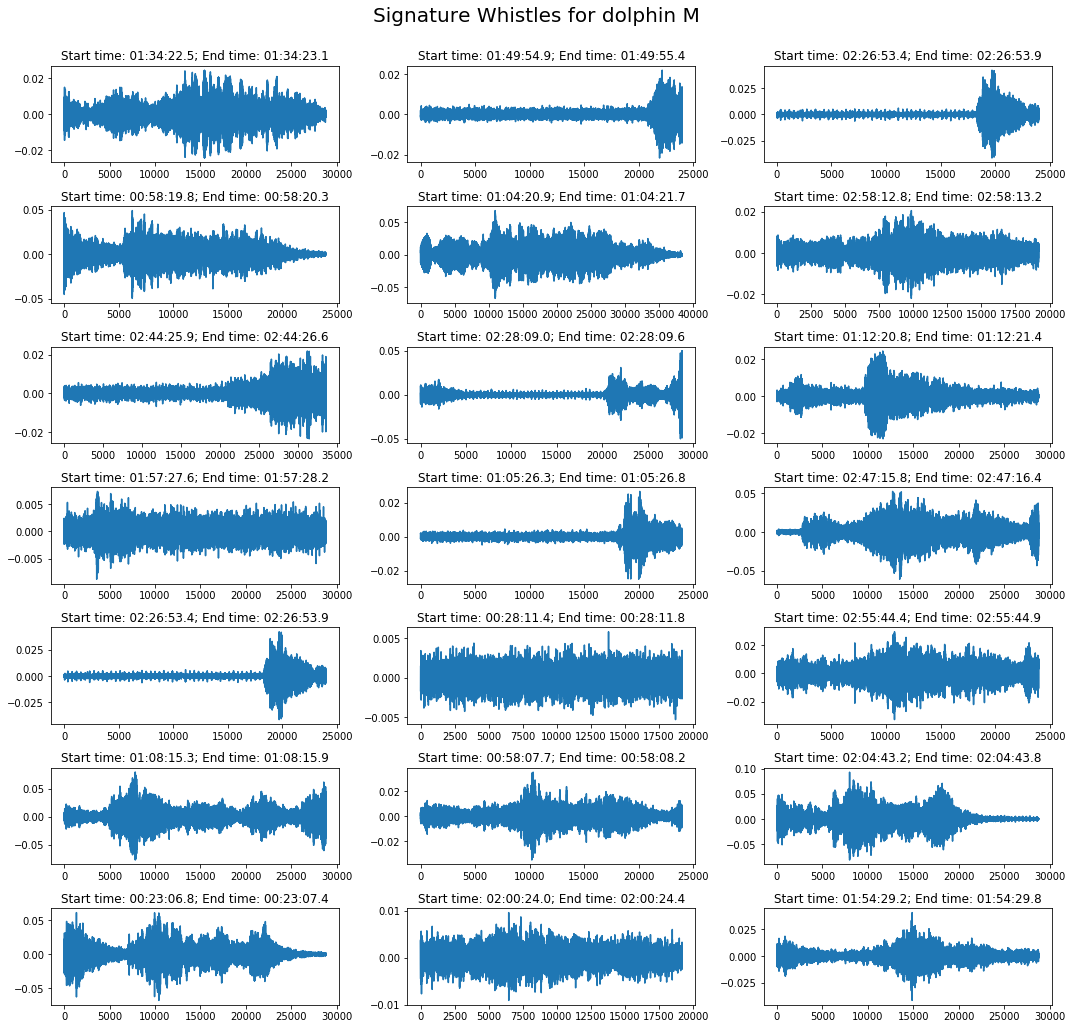

In [9]:
for dolphin in dolphins: plot_sig_whistles(dolphin, same_scale=False)